In [197]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

import numpy as np
import pandas as pd

import misc
import plotting
import stats
#import pystan

reload(misc)
reload(plotting)

#first_year = 1996
first_year = 1992

data_dir = '.'
data_file = os.path.join(data_dir, 'ssm_with_metadata_2017_03_13.csv')
data = misc.read_article_data(data_file, first_year, rename_frames=True)
print "Loaded data for %d articles" % len(data.index)

data['tone'] = data['Pro'] - data['Anti']

tone_annotations = misc.read_article_data(os.path.join(data_dir, 'samesex_tone_annotations.csv'), first_year)
print "Loaded tone annotations for %d articles" % len(tone_annotations.index)

tone_annotations['tone'] = tone_annotations['Pro'] - tone_annotations['Anti']

#framing_annotations = misc.read_article_data(os.path.join(data_dir, 'samesex_framing_annotations.csv'), first_year)
#framing_annotations = misc.compute_entropy(framing_annotations)
#print "Loaded framing annotations for %d articles" % len(framing_annotations.index)

last_date = data['date'].max()
print "Last date = ", last_date
last_year = last_date.year + 1


Loaded data for 7595 articles
Loaded tone annotations for 3230 articles
Last date =  2012-12-31 00:00:00


In [198]:
# extract periods from dates
reload(misc)
data = misc.convert_dates(data, first_year)
tone_annotations = misc.convert_dates(tone_annotations, first_year)
#framing_annotations = misc.convert_dates(framing_annotations, first_year)

Grouped data into 84 periods


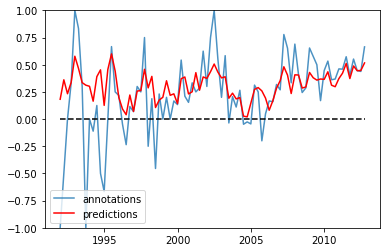

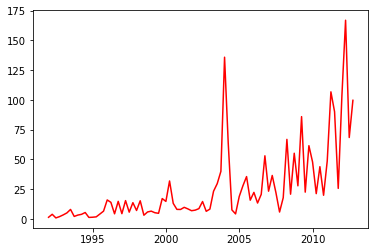

In [199]:
# decide how to group data
#group_by = 'month'
group_by = 'quarter'
#group_by = 'year'

reload(misc)
reload(plotting)

grouped = misc.group_article_data(data, group_by, first_year, group_tone=True, group_frames=True, group_directness=True)
grouped_tone_annotations = misc.group_article_data(tone_annotations, group_by, first_year, group_tone=True)
#grouped_framing_annotations = misc.group_article_data(framing_annotations, group_by, first_year, group_frames=True)

print "Grouped data into %d periods" % len(grouped.index)

fig, ax = plt.subplots()
#ax.fill_between(grouped_tone_annotations.f_date,  tone+tone_sd*2, tone-tone_sd*2, facecolor='grey', edgecolor='white', alpha=0.6)
ax.plot(grouped_tone_annotations.f_date, grouped_tone_annotations.tone / grouped_tone_annotations.stories, label='annotations', alpha=0.8)
ax.plot(grouped.f_date, grouped.tone / grouped.stories , 'r', label='predictions')
ax.plot([grouped.f_date.min(), grouped.f_date.max()], [0, 0], 'k--')
#ax.plot(grouped.f_date, grouped.Pro, c='purple', label='Pro')
#ax.plot(grouped.f_date, grouped.Anti, c='orange', label='Anti')
#ax.plot(grouped.f_date, grouped.Neutral, c='green', label='Neutral')
ax.legend(loc='lower left')
ax.set_ylim(-1, 1)

fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.tone , 'r', label='(Net) tone')


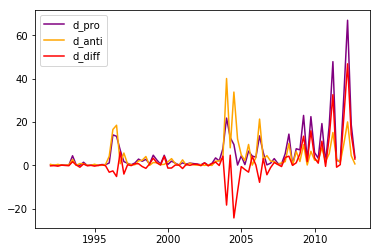

In [200]:
grouped = misc.compute_entropy(grouped)
grouped['toneXentropy'] = grouped['tone'] * grouped['entropy']
    
grouped = misc.compute_dominance(grouped)
#grouped_framing_annotations = misc.compute_entropy(grouped_framing_annotations)

fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.d_pro, c='purple', label='d_pro')
ax.plot(grouped.f_date, grouped.d_anti, c='orange', label='d_anti')
grouped['d_diff'] = grouped['d_pro'] - grouped['d_anti']
ax.plot(grouped.f_date, grouped.d_pro - grouped.d_anti, c='red', label='d_diff')
ax.legend()

#fig, ax = plt.subplots()
#ax.plot(grouped.f_date, grouped.tone * grouped.stories, c='green', label='toneXstories')
#ax.legend()

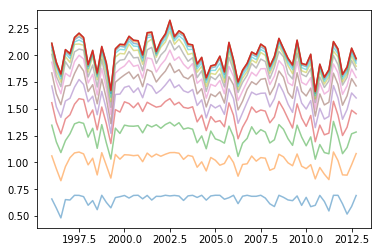

In [6]:
reload(misc)

fig, ax = plt.subplots()
grouped = misc.compute_truncated_entropy(grouped)
for j in range(2,15):
    ax.plot(grouped.f_date, grouped['entropy_' + str(j)], label='entropy_' + str(j), alpha=0.5)

ax.plot(grouped.f_date, grouped.entropy, label='entropy')

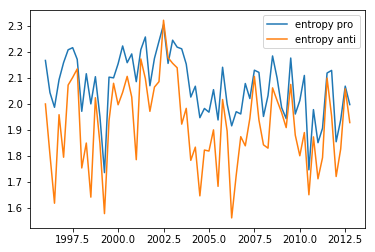

In [7]:
reload(misc)

grouped = misc.compute_signed_entropy(grouped)
fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.entropy_pro, label='entropy pro')
ax.plot(grouped.f_date, grouped.entropy_anti, label='entropy anti')
grouped['toneXentropyPro'] = grouped['tone'] * grouped['entropy_pro']
grouped['toneXentropyAnti'] = grouped['tone'] * grouped['entropy_anti']
ax.legend()

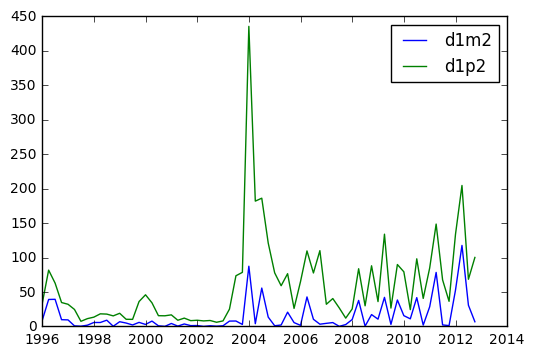

In [18]:
fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.d1m2, label='d1m2')
ax.plot(grouped.f_date, grouped.d1p2, label='d1p2')
ax.legend()
grouped['toneXd1m2'] = grouped['tone'] * grouped['d1m2']
grouped['toneXd1p2'] = grouped['tone'] * grouped['d1p2']



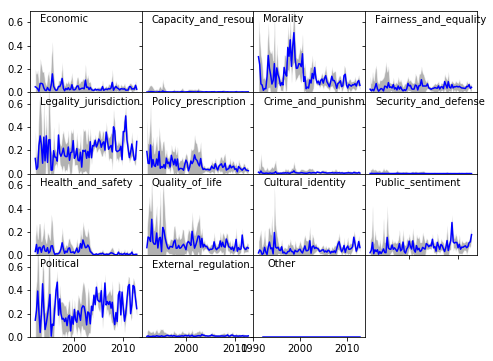

In [250]:
reload(plotting)
plotting.plot_frames(grouped, ymax=0.7)


set([4, 12, -1])
{12: '#d95f02', 4: '#1b9e77', -1: '#7570b3'}
set(['#1b9e77', '#d95f02'])


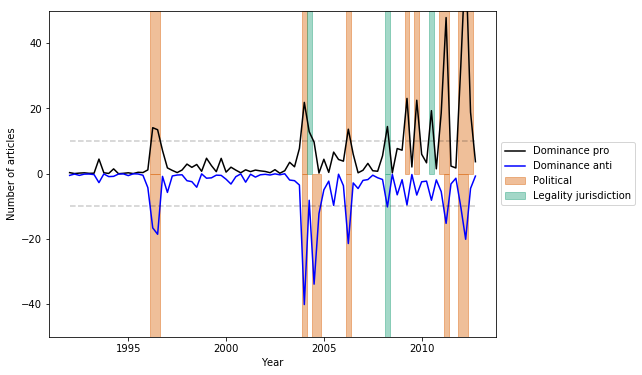

In [255]:
import re
reload(misc)
grouped = misc.compute_entropy(grouped)
grouped['toneXentropy'] = grouped['tone'] * grouped['entropy']

CB6 = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02']

threshold = 10
grouped = misc.compute_dominance(grouped, threshold=threshold)
#grouped_framing_annotations = misc.compute_entropy(grouped_framing_annotations)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(grouped.f_date, grouped.d_pro, c='black', label='Dominance pro')
ax.plot(grouped.f_date, -grouped.d_anti, c='blue', label='Dominance anti')
grouped['d_diff'] = grouped['d_pro'] - grouped['d_anti']
#grouped['d_diff2'] = grouped['d_pro2'] - grouped['d_anti2']
#ax.plot(grouped.f_date, grouped.d_pro - grouped.d_anti, c='red', label='d_diff')

pos_spans = []
anti_spans = []
pos_cur = -1
anti_cur = -1
top_set = set()
delta = grouped.iloc[1].f_date - grouped.iloc[0].f_date

for i, index in enumerate(grouped.index):
    row = grouped.loc[index]
    if row.top_pro != pos_cur:
        if i > 0 and pos_cur >= 0:
            pos_spans[-1] += [row.f_date - delta/2.0, pos_cur]
        if i < len(grouped.index) and row.top_pro >= 0:
            pos_spans.append([row.f_date - delta/2.0])
        pos_cur = row.top_pro
    if i == len(grouped.index) - 1 and pos_cur >= 0:
        pos_spans[-1] += [row.f_date + delta/2.0, pos_cur]
    top_set.add(int(row.top_pro))

    if row.top_anti != anti_cur:
        if i > 0 and anti_cur >= 0:
            anti_spans[-1] += [row.f_date - delta/2.0, anti_cur]
        if i < len(grouped.index) and row.top_anti >= 0:
            anti_spans.append([row.f_date - delta/2.0])
        anti_cur = row.top_anti
    if i == len(grouped.index) - 1 and anti_cur >= 0: 
        anti_spans[-1] += [row.f_date + delta/2.0, anti_cur]
    top_set.add(int(row.top_anti))

print top_set
    
# UNCOMMENT THIS LINE TO REFRESH COLOURS
colors = dict(zip(list(top_set), CB6))
print colors 

ylim = 50

colors_used = set()
for span in pos_spans:
    start, end, frame = span
    color = colors[frame]
    if color in colors_used:
        ax.axvspan(start, end, ymin=0.5, ymax=1, alpha=0.4, facecolor=color, edgecolor=color, label=None)
    else:
        ax.axvspan(start, end, ymin=0.5, ymax=1, alpha=0.4, facecolor=color, edgecolor=color, label=re.sub('_', ' ', misc.FRAMES[int(frame)]))
        colors_used.add(color)

for span in anti_spans:
    start, end, frame = span
    color = colors[frame]
    if color in colors_used:
        ax.axvspan(start, end, ymin=0, ymax=0.5, alpha=0.4, facecolor=color, edgecolor=color, label=None)
    else:
        ax.axvspan(start, end, ymin=0, ymax=0.5, alpha=0.4, facecolor=color, edgecolor=color, label=re.sub('_', ' ', misc.FRAMES[int(frame)]))
        colors_used.add(color)

print colors_used

ax.plot(grouped.f_date, np.ones_like(grouped.f_date)*threshold, 'k--', alpha=0.2)
ax.plot(grouped.f_date, -np.ones_like(grouped.f_date)*threshold, 'k--', alpha=0.2)
ax.set_ylim(-50, 50)
ax.set_ylabel('Number of articles')
ax.set_xlabel('Year')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('/Users/dcard/Desktop/samesex_dominance_' + str(threshold) + '.pdf', bbox_inches='tight')

1990
Loaded 164 polls
        Issue    Varname   House     Date  Topic  Subcode    L1    L2   L3  \
257  same-sex    HOMOMAR  GALLUP  3/15/96    150      151  27.0   0.0  0.0   
62   same-sex     GAYWED    PSRA  5/31/96    150      151   6.0  21.0  0.0   
248  same-sex      ABCCU   ABCWP   8/1/96    150      151  37.0   0.0  0.0   
258  same-sex    HOMOMAR  GALLUP   2/8/99    150      151  35.0   0.0  0.0   
150  same-sex  GAYWEDFOX     FOX  1/12/00    150      151  19.0  24.0  0.0   

      L4    ...     ABCCU  PSGAYUN  GAYWEDFOX  ABCBAN  MARHOMO  GAYMAR BANMAR  \
257  0.0    ...         0        0          0       0        0       0      0   
62   0.0    ...         0        0          0       0        0       0      0   
248  0.0    ...         1        0          0       0        0       0      0   
258  0.0    ...         0        0          0       0        0       0      0   
150  0.0    ...         0        0          1       0        0       0      0   

     GAYAMEND  CIVUNIO

(<matplotlib.figure.Figure at 0x12cb1a350>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12ca08550>)

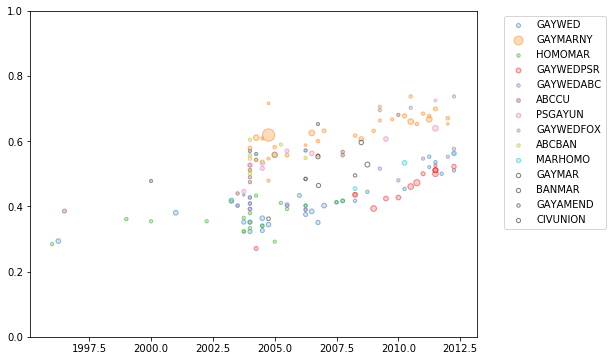

In [166]:
reload(misc)

filename = 'samesex_marriage_polls.csv'
print first_year
polls = misc.load_polls(filename, first_year, last_date)
# drop one poll that seems redundant (with a seeming mistake)
polls = polls[polls['Varname'] != 'IMMLEGAL']
polls = misc.get_f_dates(polls, first_year, group_by)
print "Loaded %d polls" % len(polls.index)

# add in indicator variables for each question
varnames = polls['Varname'].values
#questions = list(set(varnames))
#questions.sort()
questions = misc.get_top_poll_questions(polls, n=len(varnames)+1)
question_index = dict(zip(questions, range(len(questions))))    
for q_i, q in enumerate(questions):
    polls.ix[:, q] = 0
for q_i, q in enumerate(questions):
    polls.ix[polls['Varname']==q, 'question'] = q_i
    polls.ix[polls['Varname']==q, q] = 1
print polls.head() 

reload(plotting)
#plotting.plot_polling_data(polls)
plotting.plot_polling_data(polls, transform=False)

(0, 1)

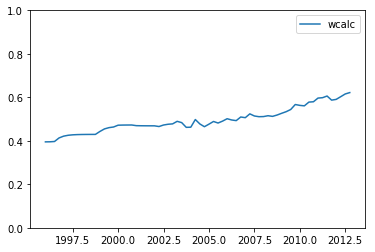

In [201]:
# Load data from wcalc
# specify the location of the mood data file
reload(misc)

group_by = 'quarter'
# read the mood data into a dataframe
if group_by == 'quarter':
    mood = pd.read_csv('wcalc_ssm_quarter_smoothed.csv', header=0)
    mood['date'] = [pd.Timestamp(pd.datetime(int(mood.loc[i].year), (int(mood.loc[i].quarter))*3, 1)) for i in mood.index]
else:
    sys.exit()

mood = mood[mood['date'] >= pd.datetime(first_year, 1, 1)]
mood = mood[mood['date'] <= last_date]  

mood = misc.convert_dates(mood, first_year)
mood = misc.get_f_dates(mood, first_year, group_by)
mood.index = mood.p_quarter

# convert each quarter to a group (year/quarter)
if group_by == 'quarter':
    groups = mood.groupby('p_quarter')
elif group_by == 'month':
    groups = mood.groupby('p_month')
else:
    sys.exit()
    
# normalize and transform mood
mood['mood'] = mood['mood'] / 100.0
mood['transformed'] = np.log(mood.mood / (1 - mood.mood))

# store the vector of mood values from the previous quarter as a separate vector
mood['prev_mood'] = mood['mood'].shift().as_matrix()
mood['prev_transformed'] = mood['transformed'].shift().as_matrix()

# copy the mood data into the grouped dataframe (with the framing data)
grouped['mood'] = mood.mood
grouped['transformed'] = mood.transformed
grouped['prev_mood'] = mood.prev_mood
grouped['prev_transformed'] = mood.prev_transformed
grouped['mood_diff'] = grouped['mood'] - grouped['prev_mood']
grouped['transformed_diff'] = grouped['transformed'] - grouped['prev_transformed']
grouped['logTone'] = np.log(grouped['tone'] / np.mean(grouped['tone']))

#temp = pd.read_csv('immigration_grouped.csv')
#grouped['p_t'] = temp['p_t_means']

fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.mood, label='wcalc')
#ax.plot(grouped.f_date, grouped.p_t, label='p_t')
ax.legend()
plt.ylim(0, 1)



In [212]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood'])


Rmse: 0.00964288309186
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     2195.
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           8.10e-52
Time:                        15:23:44   Log-Likelihood:                 216.93
No. Observations:                  67   AIC:                            -429.9
Df Residuals:                      65   BIC:                            -425.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0030      0.

ValueError: too many values to unpack

In [194]:
fitted, rmse, model = stats.ols(df=grouped, target='transformed', columns=['prev_transformed'])


Rmse: 0.0390009907351
                            OLS Regression Results                            
Dep. Variable:            transformed   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     2193.
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           8.36e-52
Time:                        14:55:49   Log-Likelihood:                 123.31
No. Observations:                  67   AIC:                            -242.6
Df Residuals:                      65   BIC:                            -238.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept         

In [210]:
reload(stats)
fitted, rmse, model = stats.ols(df=grouped, target='mood', columns=['f_date'])
print np.mean(grouped.mood - fitted)
print np.std(grouped.mood - fitted)

Rmse: 0.0175457163242
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     649.4
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           7.19e-36
Time:                        15:18:27   Log-Likelihood:                 179.45
No. Observations:                  68   AIC:                            -354.9
Df Residuals:                      66   BIC:                            -350.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -21.6531      0.8

In [204]:
fitted, rmse, model = stats.ols(df=grouped, target='mood', columns=['prev_mood'])
pred_df['ar_fit'] = fitted

Rmse: 0.00964288309186
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     2195.
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           8.10e-52
Time:                        14:59:04   Log-Likelihood:                 216.93
No. Observations:                  67   AIC:                            -429.9
Df Residuals:                      65   BIC:                            -425.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0030      0.

In [203]:
pred_df = pd.DataFrame(grouped['mood'], index=grouped.index, columns=['mood'])
pred_df['f_date'] = grouped['f_date']
pred_df['linear_fit'] = fitted


In [216]:
grouped['normalized_tone'] = grouped['tone'] / np.max(grouped['tone'].values)
fitted, rmse, model = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'normalized_tone'])
pred_df['tone_fit'] = fitted

Rmse: 0.00917373105339
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1217.
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           1.19e-51
Time:                        15:28:29   Log-Likelihood:                 220.79
No. Observations:                  67   AIC:                            -435.6
Df Residuals:                      64   BIC:                            -429.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          

In [214]:
divisor = np.max([np.max(grouped['d_pro'].values), np.max(grouped['d_anti'].values)])
grouped['normalized_d_pro'] = grouped['d_pro'] / divisor
grouped['normalized_d_anti'] = grouped['d_anti'] / divisor
fitted, rmse, dom_model = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'normalized_d_pro', 'normalized_d_anti'])
pred_df['dom_fit'] = fitted

Rmse: 0.00883268945482
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     877.1
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           2.65e-51
Time:                        15:24:08   Log-Likelihood:                 223.86
No. Observations:                  67   AIC:                            -439.7
Df Residuals:                      63   BIC:                            -430.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept      

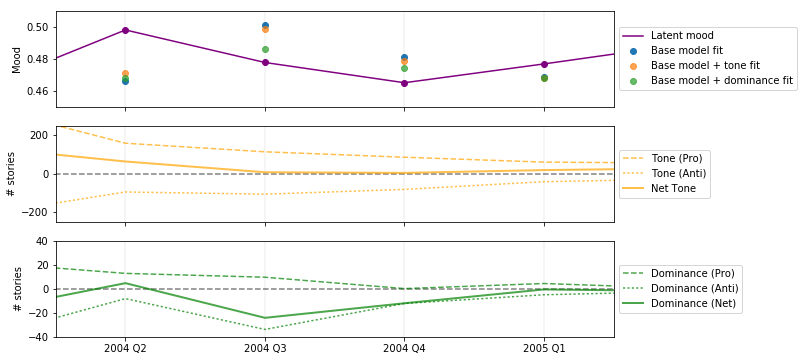

In [243]:
#plt.plot(pred_df.f_date, pred_df.mood, label='Latent mood')
#plt.plot(pred_df.f_date, pred_df.linear_fit, label='Linear fit')
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
ax, ax3, ax2 = axes
for d in grouped.f_date:
    ax.plot([d, d], [0, 1], c='k', alpha=0.05, label=None)
ax.plot(grouped.f_date, grouped.mood, c='purple', label='Latent mood')
ax.scatter(grouped.f_date, grouped.mood, c='purple', label=None)
ax.scatter(pred_df.f_date, pred_df.ar_fit, label='Base model fit')
ax.scatter(pred_df.f_date, pred_df.tone_fit, label='Base model + tone fit', alpha=0.7)
ax.scatter(pred_df.f_date, pred_df.dom_fit, label='Base model + dominance fit', alpha=0.7)
ax.set_ylim(0.45, 0.51)
ax.set_xlim(2004.125, 2005.125)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel('Mood')

for d in grouped.f_date:
    ax2.plot([d, d], [-40, 40], c='k', alpha=0.05, label=None)
ax2.plot(grouped.f_date, np.zeros_like(grouped.f_date), 'k--', label=None, alpha=0.5)
ax2.plot(grouped.f_date,  grouped.d_pro, 'g--', label='Dominance (Pro)', alpha=0.7)
ax2.plot(grouped.f_date,  -grouped.d_anti, 'g:', label='Dominance (Anti)', alpha=0.7)
ax2.plot(grouped.f_date,  grouped.d_diff, linewidth=2, c='green', label='Dominance (Net)', alpha=0.7)
#ax2.plot(grouped.f_date, -grouped.d_anti, c='red', label='Anti dominance', alpha=0.7)
#ax2.plot(grouped.f_date, grouped.d_pro/np.max(grouped.d_pro)/50.0, 'green', label='d_pro', alpha=0.7)
#ax2.plot(grouped.f_date, -grouped.d_anti/np.max(grouped.d_anti)/50.0, 'green', label='d_anti', alpha=0.7)
#ax2.plot(grouped.f_date, (grouped.mood - 0.5)/10.0, label='mood', c='purple')
#ax.plot(grouped.f_date, (grouped.tone - np.mean(grouped.tone))/np.max(grouped.tone)/100.0, c='red', label='tone')
#ax2.plot(grouped.f_date, grouped.Pro/np.max(grouped.Pro)/100.0, c='red', label='Pro')
#ax2.plot(grouped.f_date, -grouped.Anti/np.max(grouped.Anti)/100.0, c='red', label='Anti')
ax2.set_ylim(-40, 40)
ax2.set_ylabel('# stories')
ax2.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

for d in grouped.f_date:
    ax3.plot([d, d], [-250, 250], c='k', alpha=0.05, label=None)
ax3.plot(grouped.f_date, np.zeros_like(grouped.f_date), 'k--', label=None, alpha=0.5)
ax3.plot(grouped.f_date, grouped.Pro, linestyle='--', c='orange', label='Tone (Pro)', alpha=0.7)
ax3.plot(grouped.f_date, -grouped.Anti, linestyle=':', c='orange', label='Tone (Anti)', alpha=0.7)
ax3.plot(grouped.f_date, grouped.tone, linewidth=2, c='orange', label='Net Tone', alpha=0.7)
ax3.set_ylim(-250, 250)
ax3.set_ylabel('# stories')
#ax3.set_xticks([2004, 2006])
ax3.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax3.set_xticks([2004.25, 2004.5, 2004.75, 2005])
ax3.set_xticklabels(['2004 Q2', '2004 Q3', '2004 Q4', '2005 Q1'])

#for d in grouped.f_date:
#    ax4.plot([d, d], [-250, 250], c='k', alpha=0.05, label=None)
#ax4.plot(grouped.f_date, np.zeros_like(grouped.f_date), 'k--', label=None, alpha=0.5)
#ax4.plot(grouped.f_date, grouped.Legality_jurisdiction_pro, linestyle='--', c='cyan', label='Legality pro')
#ax4.plot(grouped.f_date, grouped.Political_pro,  linestyle='--',c='red', label='Political pro')
#ax4.plot(grouped.f_date, -grouped.Legality_jurisdiction_anti, linestyle=':', c='cyan', label='Legality anti')
#ax4.plot(grouped.f_date, -grouped.Political_anti,  linestyle=':' ,c='red', label='Political anti')
#ax4.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#ax4.set_ylim(-75, 75)

plt.savefig('/Users/dcard/Desktop/example.pdf', bbox_inches='tight')

In [ ]:
# Check out same-sex_marriage1.0-2475.txt

In [186]:
grouped['normalized_tone'] = grouped['tone'] / np.max(grouped['tone'].values)
fitted, rmse, model = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'normalized_tone'])


Rmse: 0.00917373105339
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1217.
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           1.19e-51
Time:                        13:47:19   Log-Likelihood:                 220.79
No. Observations:                  67   AIC:                            -435.6
Df Residuals:                      64   BIC:                            -429.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          

In [215]:
grouped['normalized_tone'] = grouped['tone'] / np.max(grouped['tone'].values)
fitted, rmse, model = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'normalized_tone'])


Rmse: 0.00917373105339
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1217.
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           1.19e-51
Time:                        15:25:56   Log-Likelihood:                 220.79
No. Observations:                  67   AIC:                            -435.6
Df Residuals:                      64   BIC:                            -429.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          

In [217]:
divisor = np.max([np.max(grouped['Pro'].values), np.max(grouped['Anti'].values)])
grouped['normalized_pro'] = grouped['Pro'] / divisor
grouped['normalized_anti'] = grouped['Anti'] / divisor
fitted, rmse, model = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'normalized_pro', 'normalized_anti'])


Rmse: 0.00880306427142
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     883.1
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           2.14e-51
Time:                        15:29:06   Log-Likelihood:                 224.08
No. Observations:                  67   AIC:                            -440.2
Df Residuals:                      63   BIC:                            -431.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          

In [181]:
divisor = np.max([np.max(grouped['d_pro'].values), np.max(grouped['d_anti'].values)])
grouped['normalized_d_pro'] = grouped['d_pro'] / divisor
grouped['normalized_d_anti'] = grouped['d_anti'] / divisor
fitted, rmse, model = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'normalized_d_pro', 'normalized_d_anti'])


Rmse: 0.00883268945482
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     877.1
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           2.65e-51
Time:                        13:46:46   Log-Likelihood:                 223.86
No. Observations:                  67   AIC:                            -439.7
Df Residuals:                      63   BIC:                            -430.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept      

In [187]:
divisor = np.max([np.max(grouped['d_pro'].values), np.max(grouped['d_anti'].values)])
grouped['normalized_d_pro'] = grouped['d_pro'] / divisor
grouped['normalized_d_anti'] = grouped['d_anti'] / divisor
fitted, rmse, model = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'normalized_tone', 'normalized_d_pro', 'normalized_d_anti'])


Rmse: 0.00840804140328
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     727.8
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           2.46e-51
Time:                        13:56:52   Log-Likelihood:                 227.69
No. Observations:                  67   AIC:                            -445.4
Df Residuals:                      62   BIC:                            -434.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept      

In [182]:
divisor = np.max([np.max(grouped['d_pro'].values), np.max(grouped['d_anti'].values)])
grouped['normalized_d_pro'] = grouped['d_pro'] / divisor
grouped['normalized_d_anti'] = grouped['d_anti'] / divisor
fitted, rmse, model = stats.ols(df=grouped, target='transformed', columns=['prev_transformed', 'normalized_d_pro', 'normalized_d_anti'])


Rmse: 0.035673753967
                            OLS Regression Results                            
Dep. Variable:            transformed   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     878.7
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           2.50e-51
Time:                        13:46:50   Log-Likelihood:                 130.33
No. Observations:                  67   AIC:                            -252.7
Df Residuals:                      63   BIC:                            -243.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept        

In [183]:
divisor = np.max([np.max(grouped['d_pro'].values), np.max(grouped['d_anti'].values)])
#grouped['normalized_d_pro'] = grouped['d_pro'] / divisor
#grouped['normalized_d_anti'] = grouped['d_anti'] / divisor
grouped['normalized_d_diff'] = grouped['d_diff'] / np.max(np.abs(grouped['d_diff']))
fitted, rmse, model = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'normalized_d_diff'])


Rmse: 0.00879045431593
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1328.
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           7.78e-53
Time:                        13:46:54   Log-Likelihood:                 223.65
No. Observations:                  67   AIC:                            -441.3
Df Residuals:                      64   BIC:                            -434.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept      

In [24]:
fitted, rmse, model = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'tone', 'entropy'])


Rmse: 0.00923421018245
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     800.7
Date:                Wed, 05 Apr 2017   Prob (F-statistic):           4.35e-50
Time:                        15:50:23   Log-Likelihood:                 220.88
No. Observations:                  67   AIC:                            -433.8
Df Residuals:                      63   BIC:                            -424.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0280      0.

In [25]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'tone', 'entropy', 'toneXentropy'])


Rmse: 0.00930812486888
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     591.0
Date:                Wed, 05 Apr 2017   Prob (F-statistic):           1.34e-48
Time:                        15:50:23   Log-Likelihood:                 220.88
No. Observations:                  67   AIC:                            -431.8
Df Residuals:                      62   BIC:                            -420.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        0.0290  

In [26]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'd_diff'])


Rmse: 0.00879045431593
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1328.
Date:                Wed, 05 Apr 2017   Prob (F-statistic):           7.78e-53
Time:                        15:50:24   Log-Likelihood:                 223.65
No. Observations:                  67   AIC:                            -441.3
Df Residuals:                      64   BIC:                            -434.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0212      0.

In [27]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood',  'd_pro', 'd_anti'])


Rmse: 0.00883268945482
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     877.1
Date:                Wed, 05 Apr 2017   Prob (F-statistic):           2.65e-51
Time:                        15:50:25   Log-Likelihood:                 223.86
No. Observations:                  67   AIC:                            -439.7
Df Residuals:                      63   BIC:                            -430.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0208      0.

In [28]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood',  'tone', 'd1m2', 'toneXd1m2'])


Rmse: 0.00893548571422
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     642.6
Date:                Wed, 05 Apr 2017   Prob (F-statistic):           1.07e-49
Time:                        15:50:26   Log-Likelihood:                 223.62
No. Observations:                  67   AIC:                            -437.2
Df Residuals:                      62   BIC:                            -426.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0279      0.

In [219]:
columns = ['prev_mood']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

columns = ['prev_mood', 'tone']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns


columns = ['prev_mood', 'Pro', 'Anti']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

columns = ['prev_mood', 'd_pro', 'd_anti']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

Held-out RMSE: 0.00978122634253 ['prev_mood']
Held-out RMSE: 0.00956258281262 ['prev_mood', 'tone']
Held-out RMSE: 0.00921776257554 ['prev_mood', 'Pro', 'Anti']
Held-out RMSE: 0.0092651441625 ['prev_mood', 'd_pro', 'd_anti']


In [25]:
# MODEL with no temporal covariates (just polls)

model = """
/*
* Simple latent space model for mood
*/

data {
  int N; // number of polls
  int T; // number of time steps
  int Q; // number of different questions
  int y[N]; // poll results
  int t[N]; // time indicies of polls
  int n[N]; // sample size for each poll
  row_vector[Q] q[N];  // indicators for poll questions
  int N_new;          // number of test points
  int y_new[N_new];
  int t_new[N_new];
  int n_new[N_new];
  row_vector[Q] q_new[N_new];
}
parameters {
  real<lower=0, upper=1> p_t_0; // unconstrained latent mood at timestep 0
  vector[T] mu;  // latent mood variable in real space
  real<lower=0> sigma_mu;  // variance of transitions in mu
  vector[Q] offsets; // offset for each question in real space
  real offset_mean;
  real<lower=0> offset_var; // offset variance 
  real alpha; // intercept in AR model
  real alpha_mean;
  real<lower=0> alpha_var;
  real beta; // weight parameter on previous mu
  real beta_mean; 
  real<lower=0> beta_var;
}
transformed parameters {  
  real mu_0;  // p_t_0 transformed to real space
  mu_0 = logit(p_t_0);
}
model {  
  sigma_mu ~ cauchy(0, 2.5);
  alpha_var ~ cauchy(0, 2.5);
  alpha_mean ~ normal(0, 1);
  alpha ~ normal(alpha_mean, alpha_var);
  beta_var ~ cauchy(0, 2.5);
  beta_mean ~ normal(1, 1);  // assume mu[t] \approx mu[t-1] as a prior
  beta ~ normal(beta_mean, beta_var);

p_t_0 ~ uniform(0, 1);
  mu[1] ~ normal(alpha + beta * mu_0, sigma_mu);
  for (j in 2:T) {
    mu[j] ~ normal(alpha + beta * mu[j-1], sigma_mu);
  }
  offset_var ~ cauchy(0, 2.5);
  offset_mean ~ normal(0, 1);
  for (k in 1:Q) {
     offsets[k] ~ normal(offset_mean, offset_var);
  }
  for (i in 1:N) {
    y[i] ~ binomial_logit(n[i], mu[t[i]] + q[i] * offsets);
  }
}
generated quantities {
  vector[T] p_t; // mu variables transformed into (0, 1)
  vector[N] p_i; 
  vector[N_new] p_i_new;

  // store the log prob of held out observations
  real log_p_new;        // posterior predictive log density remaining trials
  vector[N_new] log_p_news;  // posterior predictive log density for item  
  
  // store simulated draws from the posterior
  int<lower=0> s_new[N_new];

  for (j in 1:T)
    p_t[j] = inv_logit(mu[j] + offset_mean);
  for (i in 1:N)
    p_i[i] = inv_logit(mu[t[i]] + q[i] * offsets);
  for (i in 1:N_new)
    p_i_new[i] = inv_logit(mu[t_new[i]] + q_new[i] * offsets);

  // calculate likelihood of held-out data
  for (i in 1:N_new)
    log_p_news[i] = binomial_lpmf(y_new[i] | n_new[i], p_i_new[i]);
  log_p_new = sum(log_p_news);  // sum the log probs of each obseration
  
  // simluate data from posterior for posterior predictive checks
  for (i in 1:N_new) {
    s_new[i] = binomial_rng(n_new[i], p_i_new[i]);
  }
}
"""



In [27]:
tones = grouped.tone.values
logStories = grouped.logStories.values
toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy
X = np.vstack([tones, logStories, entropy, toneXentropy]).T
n_periods, K = X.shape
n_polls, _ = polls.shape
periods = np.array(polls.p_quarter.values, dtype=int) + 1
n_questions = int(polls.question.max() + 1) 
question_indices = np.array(polls.question.values, dtype=int) + 1
question_indicators = np.zeros([n_polls, n_questions])
for i in range(n_polls):
    question_indicators[i, polls.question.values[i]] = 1
    
y = np.array((polls.value * polls.N).values, dtype=int)
t = np.array(polls.p_quarter.values, dtype=int) + 1
stan_data = {'N': n_polls, 'T': n_periods, 'Q': n_questions,
             'y': y, 't': periods, 'n': polls.N.values, 'q': question_indicators,
             'N_new': n_polls,
             'y_new': y, 't_new': periods, 'n_new': polls.N.values, 'q_new': question_indicators}
n_chains = 4
n_iter = 2000
fit = pystan.stan(model_code=model, data=stan_data, iter=n_iter, chains=4)


/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


Question	Responses
  GAYWED	43
GAYMARNY	33
 HOMOMAR	19
GAYWEDPSR	15
GAYWEDABC	11
   ABCCU	9
 PSGAYUN	9
GAYWEDFOX	8
  ABCBAN	7
 MARHOMO	3
  GAYMAR	2
  BANMAR	2
GAYAMEND	2
CIVUNION	1


''

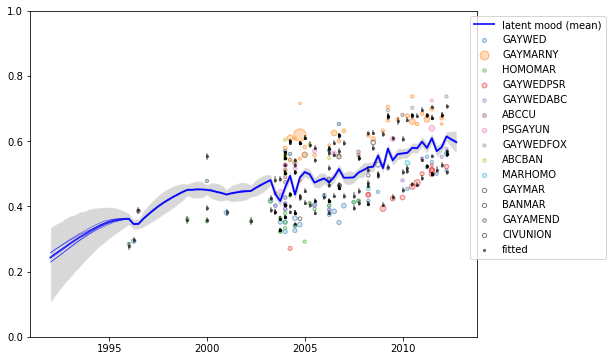

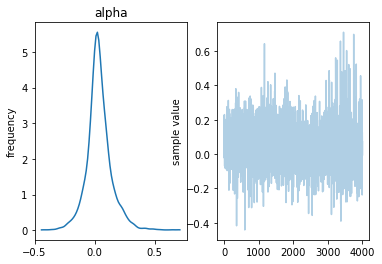

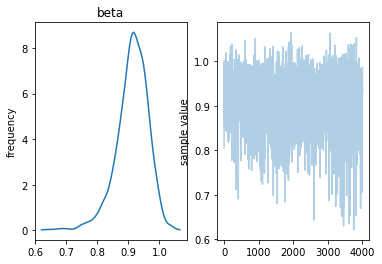

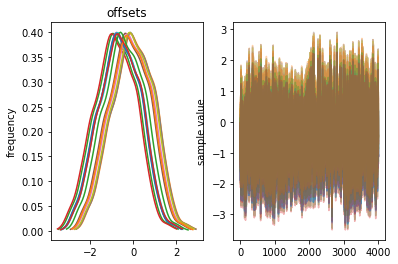

In [33]:
reload(plotting)

p_t = fit.extract('p_t')['p_t']
p_i = fit.extract('p_i')['p_i']
p_t_means = np.mean(p_t, axis=0)
p_t_25 = np.percentile(p_t, 25, axis=0)
p_t_75 = np.percentile(p_t, 75, axis=0)
p_i_means = np.mean(p_i, axis=0)
p_i_25 = np.percentile(p_i, 25, axis=0)
p_i_75 = np.percentile(p_i, 75, axis=0)
fig, ax = plotting.plot_polling_data(polls)
x = [first_year + (q) * 0.25 for q in range(n_periods)]
ax.fill_between(x,  p_t_25, p_t_75, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
for i in range(n_chains):
    ax.plot(x, np.mean(p_t[i*n_iter/2:(i+1)*n_iter/2, :], axis=0), 'b', linewidth=0.5, alpha=0.8, label=None)    
ax.plot(x, p_t_means, 'b', linewidth=2, alpha=0.8, label='latent mood (mean)')
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
ax.scatter(polls.f_date, p_i_means, s=5, facecolor='black', edgecolor='black', label='fitted', alpha=0.5)
for i in range(n_polls):
    f_date = polls.f_date.iloc[i]
    ax.plot([f_date, f_date], [p_i_25[i], p_i_75[i]], 'k', label=None, alpha=0.5)
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

fit.plot('alpha')
fit.plot('beta')
#fit.plot('gamma')
fit.plot('offsets')

""

/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


Question	Responses
  GAYWED	40
GAYMARNY	33
GAYWEDPSR	15
 HOMOMAR	15
GAYWEDABC	11
 PSGAYUN	9
   ABCCU	8
GAYWEDFOX	7
  ABCBAN	7
 MARHOMO	3
  GAYMAR	2
  BANMAR	2
GAYAMEND	2
CIVUNION	1
fold 0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


fold 1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


fold 2


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


fold 3


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


fold 4
log_p_new: -388.08


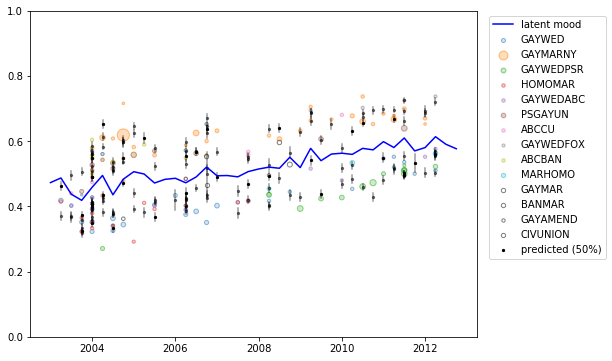

In [26]:
fig, ax = plotting.plot_polling_data(polls)

n_questions = int(polls.question.max() + 1)
n_periods = len(grouped.index)
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
p_t_mean = np.zeros(n_periods)

n_folds = 5
for fold in range(n_folds):
    print "fold", fold
    polls_train = polls[polls.fold != fold]
    polls_test = polls[polls.fold == fold]
    N_train, _ = polls_train.shape
    N_test, _ = polls_test.shape
    question_indices = np.array(polls.question.values, dtype=int) + 1
    question_indicators_train = np.zeros([N_train, n_questions])
    question_indicators_test = np.zeros([N_test, n_questions])
    for i in range(N_train):
        question_indicators_train[i, polls_train.question.values[i]] = 1
    for i in range(N_test):
        question_indicators_test[i, polls_test.question.values[i]] = 1

    y_train = np.array((polls_train.value * polls_train.N).values, dtype=int)
    y_test = np.array((polls_test.value * polls_test.N).values, dtype=int)
    t_train = np.array(polls_train.period.values, dtype=int) + 1
    t_test = np.array(polls_test.period.values, dtype=int) + 1
        
    stan_data = {'N': N_train, 'T': n_periods, 'Q': n_questions,
                 'y': y_train, 't': t_train, 'n': polls_train.N.values, 'q': question_indicators_train,
                 'N_new': N_test,
                 'y_new': y_test, 't_new': t_test, 'n_new': polls_test.N.values, 'q_new': question_indicators_test}
    fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

    p_t = fit.extract('p_t')['p_t']
    p_t_mean += np.mean(p_t, axis=0)
    p_i_new = fit.extract('p_i_new')['p_i_new']
    p_i_new_means = np.mean(p_i_new, axis=0)
    p_i_new_25 = np.percentile(p_i_new, 25, axis=0)
    p_i_new_75 = np.percentile(p_i_new, 75, axis=0)
    s_new = fit.extract('s_new')['s_new'] 
    s_new_mean = np.mean(s_new, axis=0) / polls_test.N.values
    s_new_25 = np.percentile(s_new, 25, axis=0) / polls_test.N.values
    s_new_75 = np.percentile(s_new, 75, axis=0) / polls_test.N.values
    x = [first_year + (q) * 0.25 for q in range(n_periods)]
    #ax.fill_between(x,  p_t_means+p_t_std*2, p_t_means-p_t_std*2, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
    if fold == 0:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label='latent mood')
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label='predicted (50%)')
    else:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label=None)
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label=None, alpha=0.5)
    for i in range(N_test):
        f_date = polls_test.f_date.iloc[i]
        ax.plot([f_date, f_date], [s_new_25[i], s_new_75[i]], 'k', label=None, alpha=0.4)

ax.plot(x, p_t_mean/float(n_folds), 'b', label='latent mood')
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive

In [27]:
# EXTEND MODEL with weights and covariates

model = """
/*
* Simple latent space model for mood
*/

data {
  int N; // number of polls
  int T; // number of time steps
  int Q; // number of different questions
  int K; // number of covariates
  row_vector[K] X[T];  // covariates: shape of matrix[T, K]
  int y[N]; // poll results
  int t[N]; // time indicies of polls
  int n[N]; // sample size for each poll
  row_vector[Q] q[N];  // indicators for poll questions
  int N_new;          // number of test points
  int y_new[N_new];
  int t_new[N_new];
  int n_new[N_new];
  row_vector[Q] q_new[N_new];
}
parameters {
  real<lower=0, upper=1> p_t_0; // unconstrained latent mood at timestep 0
  vector[T] mu;  // latent mood variable in real space
  real<lower=0> sigma_mu;  // variance of transitions in mu
  vector[Q] offsets; // offset for each question in real space
  real offset_mean;
  real<lower=0> offset_var; // offset variance 
  real alpha; // intercept in AR model
  real alpha_mean;
  real<lower=0> alpha_var;
  real beta; // weight parameter on previous mu
  real beta_mean; 
  real<lower=0> beta_var;
  vector[K] gamma; // weights on covariates
  real gamma_mean;
}
transformed parameters {  
  real mu_0;  // p_t_0 transformed to real space
  mu_0 = logit(p_t_0);
}
model {  
  sigma_mu ~ cauchy(0, 2.5);
  alpha_var ~ cauchy(0, 2.5);
  alpha_mean ~ normal(0, 1);
  alpha ~ normal(alpha_mean, alpha_var);
  beta_var ~ cauchy(0, 2.5);
  beta_mean ~ normal(1, 1);  // assume mu[t] \approx mu[t-1] as a prior
  beta ~ normal(beta_mean, beta_var);
  gamma_mean ~ normal(0, 1);
  for (k in 1:K)
    gamma[k] ~ normal(gamma_mean, beta_var);  // use same variance as weight on previous mu

  p_t_0 ~ uniform(0, 1);
  mu[1] ~ normal(alpha + beta * mu_0 + X[1] * gamma, sigma_mu);
  for (j in 2:T) {
    mu[j] ~ normal(alpha + beta * mu[j-1] + X[j] * gamma, sigma_mu);
  }
  offset_var ~ cauchy(0, 2.5);
  offset_mean ~ normal(0, 1);
  for (k in 1:Q) {
     offsets[k] ~ normal(offset_mean, offset_var);
  }
  for (i in 1:N) {
    y[i] ~ binomial_logit(n[i], mu[t[i]] + q[i] * offsets);
  }
}
generated quantities {
  vector[T] p_t; // mu variables transformed into (0, 1)
  vector[N] p_i; 
  vector[N_new] p_i_new;

  // store the log prob of held out observations
  real log_p_new;        // posterior predictive log density remaining trials
  vector[N_new] log_p_news;  // posterior predictive log density for item  
  
  // store simulated draws from the posterior
  int<lower=0> s_new[N_new];

  for (j in 1:T)
    p_t[j] = inv_logit(mu[j] + offset_mean);
  for (i in 1:N)
    p_i[i] = inv_logit(mu[t[i]] + q[i] * offsets);
  for (i in 1:N_new)
    p_i_new[i] = inv_logit(mu[t_new[i]] + q_new[i] * offsets);

  // calculate likelihood of held-out data
  for (i in 1:N_new)
    log_p_news[i] = binomial_lpmf(y_new[i] | n_new[i], p_i_new[i]);
  log_p_new = sum(log_p_news);  // sum the log probs of each obseration
  
  // simluate data from posterior for posterior predictive checks
  for (i in 1:N_new) {
    s_new[i] = binomial_rng(n_new[i], p_i_new[i]);
  }
}
"""



Question	Responses
  GAYWED	40
GAYMARNY	33
GAYWEDPSR	15
 HOMOMAR	15
GAYWEDABC	11
 PSGAYUN	9
   ABCCU	8
GAYWEDFOX	7
  ABCBAN	7
 MARHOMO	3
  GAYMAR	2
  BANMAR	2
GAYAMEND	2
CIVUNION	1
(40, 3)
fold 0


/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.81248777  0.01341152 -0.30231062]
[ 0.36482673  0.05013503  0.27425401]
fold 1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.65817404  0.02950029 -0.23158895]
[ 0.20412179  0.02565145  0.1778978 ]
fold 2


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.72489754  0.07918434 -0.13883684]
[ 0.38122209  0.05436026  0.29497224]
fold 3


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.37387829  0.06384631 -0.13723357]
[ 0.30225073  0.0419341   0.23818101]
fold 4
[ 0.53287672  0.04791    -0.21833722]
[ 0.34932345  0.045581    0.27571321]
log_p_new: -383.98


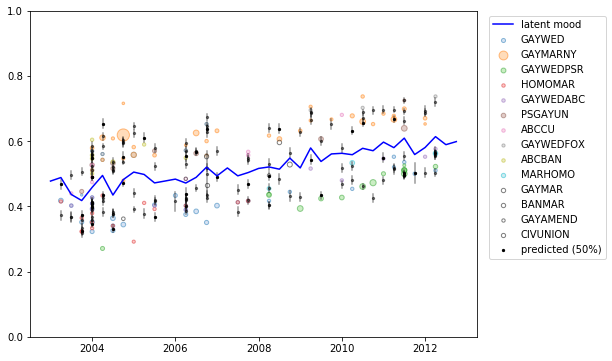

In [28]:
# TONE, logSTORIES, ENTROPY

fig, ax = plotting.plot_polling_data(polls)

n_questions = int(polls.question.max() + 1)
n_periods = len(grouped.index)
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
p_t_mean = np.zeros(n_periods)

tones = grouped.tone.values
logStories = grouped.logStories.values
toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy

X = np.vstack([tones, logStories, entropy]).T
n_periods, K = X.shape
print X.shape

n_folds = 5
for fold in range(n_folds):
    print "fold", fold
    polls_train = polls[polls.fold != fold]
    polls_test = polls[polls.fold == fold]
    N_train, _ = polls_train.shape
    N_test, _ = polls_test.shape
    question_indices = np.array(polls.question.values, dtype=int) + 1
    question_indicators_train = np.zeros([N_train, n_questions])
    question_indicators_test = np.zeros([N_test, n_questions])
    for i in range(N_train):
        question_indicators_train[i, polls_train.question.values[i]] = 1
    for i in range(N_test):
        question_indicators_test[i, polls_test.question.values[i]] = 1

    y_train = np.array((polls_train.value * polls_train.N).values, dtype=int)
    y_test = np.array((polls_test.value * polls_test.N).values, dtype=int)
    t_train = np.array(polls_train.period.values, dtype=int) + 1
    t_test = np.array(polls_test.period.values, dtype=int) + 1
        
    stan_data = {'N': N_train, 'T': n_periods, 'K':K, 'Q': n_questions,
                 'y': y_train, 't': t_train, 'n': polls_train.N.values, 'q': question_indicators_train, 'X': X,
                 'N_new': N_test,
                 'y_new': y_test, 't_new': t_test, 'n_new': polls_test.N.values, 'q_new': question_indicators_test}
    fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

    p_t = fit.extract('p_t')['p_t']
    p_t_mean += np.mean(p_t, axis=0)
    p_i_new = fit.extract('p_i_new')['p_i_new']
    p_i_new_means = np.mean(p_i_new, axis=0)
    p_i_new_25 = np.percentile(p_i_new, 25, axis=0)
    p_i_new_75 = np.percentile(p_i_new, 75, axis=0)
    s_new = fit.extract('s_new')['s_new'] 
    s_new_mean = np.mean(s_new, axis=0) / polls_test.N.values
    s_new_25 = np.percentile(s_new, 25, axis=0) / polls_test.N.values
    s_new_75 = np.percentile(s_new, 75, axis=0) / polls_test.N.values
    x = [first_year + (q) * 0.25 for q in range(n_periods)]
    #ax.fill_between(x,  p_t_means+p_t_std*2, p_t_means-p_t_std*2, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
    if fold == 0:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label='latent mood')
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label='predicted (50%)')
    else:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label=None)
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label=None, alpha=0.5)
    for i in range(N_test):
        f_date = polls_test.f_date.iloc[i]
        ax.plot([f_date, f_date], [s_new_25[i], s_new_75[i]], 'k', label=None, alpha=0.4)
        
    gamma = fit.extract('gamma')['gamma']
    print np.mean(gamma, axis=0)
    print np.std(gamma, axis=0)

ax.plot(x, p_t_mean/float(n_folds), 'b', label='latent mood')
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive

Question	Responses
  GAYWED	40
GAYMARNY	33
GAYWEDPSR	15
 HOMOMAR	15
GAYWEDABC	11
 PSGAYUN	9
   ABCCU	8
GAYWEDFOX	7
  ABCBAN	7
 MARHOMO	3
  GAYMAR	2
  BANMAR	2
GAYAMEND	2
CIVUNION	1
(40, 4)
fold 0


/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.64293477 -0.15551668 -0.25592524  0.58037504]
[ 0.30621151  0.11383399  0.25221388  0.35006641]
fold 1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.56857157 -0.04873656 -0.21492636  0.2669894 ]
[ 0.19921317  0.06215188  0.16508621  0.19411561]
fold 2


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.60553568 -0.08392043 -0.11348053  0.54643786]
[ 0.30772697  0.12061624  0.26177971  0.34783197]
fold 3


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.30930937 -0.05463636 -0.1303523   0.40710844]
[ 0.26110531  0.09858632  0.22634243  0.29385368]
fold 4
[ 0.42198506 -0.08438262 -0.20816531  0.44598796]
[ 0.2958045   0.11044502  0.24086921  0.31837128]
log_p_new: -388.35


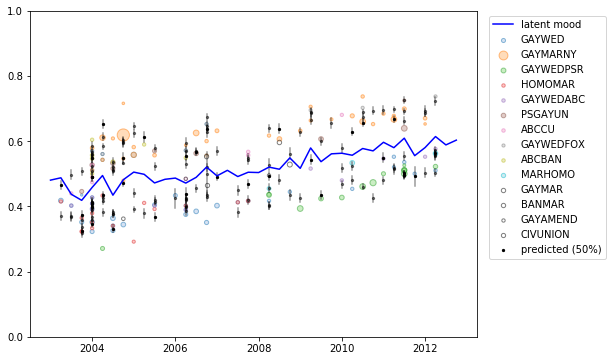

In [29]:
# TONE, logSTORIES, ENTROPY, TONE x logSTORIES

fig, ax = plotting.plot_polling_data(polls)

n_questions = int(polls.question.max() + 1)
n_periods = len(grouped.index)
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
p_t_mean = np.zeros(n_periods)

tones = grouped.tone.values
logStories = grouped.logStories.values
toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy

X = np.vstack([tones, logStories, entropy, toneXlogStories]).T
n_periods, K = X.shape
print X.shape

n_folds = 5
for fold in range(n_folds):
    print "fold", fold
    polls_train = polls[polls.fold != fold]
    polls_test = polls[polls.fold == fold]
    N_train, _ = polls_train.shape
    N_test, _ = polls_test.shape
    question_indices = np.array(polls.question.values, dtype=int) + 1
    question_indicators_train = np.zeros([N_train, n_questions])
    question_indicators_test = np.zeros([N_test, n_questions])
    for i in range(N_train):
        question_indicators_train[i, polls_train.question.values[i]] = 1
    for i in range(N_test):
        question_indicators_test[i, polls_test.question.values[i]] = 1

    y_train = np.array((polls_train.value * polls_train.N).values, dtype=int)
    y_test = np.array((polls_test.value * polls_test.N).values, dtype=int)
    t_train = np.array(polls_train.period.values, dtype=int) + 1
    t_test = np.array(polls_test.period.values, dtype=int) + 1
        
    stan_data = {'N': N_train, 'T': n_periods, 'K':K, 'Q': n_questions,
                 'y': y_train, 't': t_train, 'n': polls_train.N.values, 'q': question_indicators_train, 'X': X,
                 'N_new': N_test,
                 'y_new': y_test, 't_new': t_test, 'n_new': polls_test.N.values, 'q_new': question_indicators_test}
    fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

    p_t = fit.extract('p_t')['p_t']
    p_t_mean += np.mean(p_t, axis=0)
    p_i_new = fit.extract('p_i_new')['p_i_new']
    p_i_new_means = np.mean(p_i_new, axis=0)
    p_i_new_25 = np.percentile(p_i_new, 25, axis=0)
    p_i_new_75 = np.percentile(p_i_new, 75, axis=0)
    s_new = fit.extract('s_new')['s_new'] 
    s_new_mean = np.mean(s_new, axis=0) / polls_test.N.values
    s_new_25 = np.percentile(s_new, 25, axis=0) / polls_test.N.values
    s_new_75 = np.percentile(s_new, 75, axis=0) / polls_test.N.values
    x = [first_year + (q) * 0.25 for q in range(n_periods)]
    #ax.fill_between(x,  p_t_means+p_t_std*2, p_t_means-p_t_std*2, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
    if fold == 0:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label='latent mood')
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label='predicted (50%)')
    else:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label=None)
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label=None, alpha=0.5)
    for i in range(N_test):
        f_date = polls_test.f_date.iloc[i]
        ax.plot([f_date, f_date], [s_new_25[i], s_new_75[i]], 'k', label=None, alpha=0.4)
        
    gamma = fit.extract('gamma')['gamma']
    print np.mean(gamma, axis=0)
    print np.std(gamma, axis=0)

ax.plot(x, p_t_mean/float(n_folds), 'b', label='latent mood')
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive

Question	Responses
  GAYWED	43
GAYMARNY	33
 HOMOMAR	19
GAYWEDPSR	15
GAYWEDABC	11
   ABCCU	9
 PSGAYUN	9
GAYWEDFOX	8
  ABCBAN	7
 MARHOMO	3
  GAYMAR	2
  BANMAR	2
GAYAMEND	2
CIVUNION	1
(84, 4)
fold 0


/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.27486925  0.06065365 -0.23309703  0.16460083]
[ 0.54882889  0.02761426  0.27018934  0.2803369 ]
fold 1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.23643586  0.10788638 -0.0565024   0.21785064]
[ 0.37221281  0.03638413  0.24760247  0.21314606]
fold 2


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.12824     0.07327842 -0.03744653  0.12160743]
[ 0.31174319  0.02414098  0.16965235  0.17092628]
fold 3


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.1414655   0.08127036  0.02463362  0.11834153]
[ 0.33989224  0.02879771  0.14439287  0.18176757]
fold 4
[ 0.32809501  0.06284251 -0.11920529  0.14533608]
[ 0.7070538   0.03589168  0.26795493  0.36058617]
log_p_new: -599.20


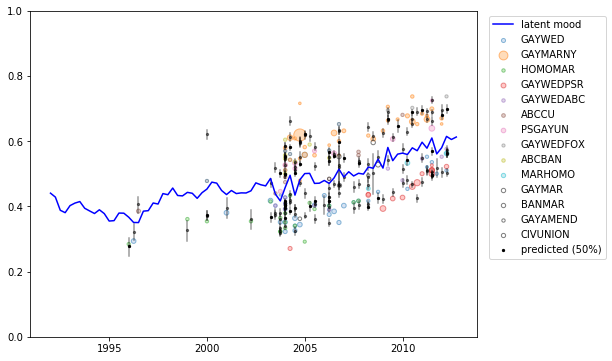

In [16]:
# TONE, logSTORIES, ENTROPY, TONE x ENTROPY

fig, ax = plotting.plot_polling_data(polls)

n_questions = int(polls.question.max() + 1)
n_periods = len(grouped.index)
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
p_t_mean = np.zeros(n_periods)

tones = grouped.tone.values
logStories = grouped.logStories.values
toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy

X = np.vstack([tones, logStories, entropy, toneXentropy]).T
n_periods, K = X.shape
print X.shape

n_folds = 5
for fold in range(n_folds):
    print "fold", fold
    polls_train = polls[polls.fold != fold]
    polls_test = polls[polls.fold == fold]
    N_train, _ = polls_train.shape
    N_test, _ = polls_test.shape
    question_indices = np.array(polls.question.values, dtype=int) + 1
    question_indicators_train = np.zeros([N_train, n_questions])
    question_indicators_test = np.zeros([N_test, n_questions])
    for i in range(N_train):
        question_indicators_train[i, polls_train.question.values[i]] = 1
    for i in range(N_test):
        question_indicators_test[i, polls_test.question.values[i]] = 1

    y_train = np.array((polls_train.value * polls_train.N).values, dtype=int)
    y_test = np.array((polls_test.value * polls_test.N).values, dtype=int)
    t_train = np.array(polls_train.period.values, dtype=int) + 1
    t_test = np.array(polls_test.period.values, dtype=int) + 1
        
    stan_data = {'N': N_train, 'T': n_periods, 'K':K, 'Q': n_questions,
                 'y': y_train, 't': t_train, 'n': polls_train.N.values, 'q': question_indicators_train, 'X': X,
                 'N_new': N_test,
                 'y_new': y_test, 't_new': t_test, 'n_new': polls_test.N.values, 'q_new': question_indicators_test}
    fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

    p_t = fit.extract('p_t')['p_t']
    p_t_mean += np.mean(p_t, axis=0)
    p_i_new = fit.extract('p_i_new')['p_i_new']
    p_i_new_means = np.mean(p_i_new, axis=0)
    p_i_new_25 = np.percentile(p_i_new, 25, axis=0)
    p_i_new_75 = np.percentile(p_i_new, 75, axis=0)
    s_new = fit.extract('s_new')['s_new'] 
    s_new_mean = np.mean(s_new, axis=0) / polls_test.N.values
    s_new_25 = np.percentile(s_new, 25, axis=0) / polls_test.N.values
    s_new_75 = np.percentile(s_new, 75, axis=0) / polls_test.N.values
    x = [first_year + (q) * 0.25 for q in range(n_periods)]
    #ax.fill_between(x,  p_t_means+p_t_std*2, p_t_means-p_t_std*2, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
    if fold == 0:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label='latent mood')
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label='predicted (50%)')
    else:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label=None)
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label=None, alpha=0.5)
    for i in range(N_test):
        f_date = polls_test.f_date.iloc[i]
        ax.plot([f_date, f_date], [s_new_25[i], s_new_75[i]], 'k', label=None, alpha=0.4)
        
    gamma = fit.extract('gamma')['gamma']
    print np.mean(gamma, axis=0)
    print np.std(gamma, axis=0)

ax.plot(x, p_t_mean/float(n_folds), 'b', label='latent mood')
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive